# Wine Quality Analysis and Prediction using kNN Classifier built from scratch

---
## 0. Loading Libraries and Data

In [106]:
# Loading libraries
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import time
import collections
import numpy as np
import math
from IPython.display import Markdown, display
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import pairwise
from sklearn.preprocessing import label_binarize
from sklearn import metrics

COUNT = 1
DISTANCE_WEIGHTED = 2
EUCLID = 3
COSINE = 4

%matplotlib inline


def printmd(string):
    display(Markdown(string))

In [107]:
# Data load
wine = pd.read_csv('winequality-red.csv', sep = ';')

---
## 1. Converting to a Binary (Low/ High Quality) Classification Problem

      class
High    855
Low     744


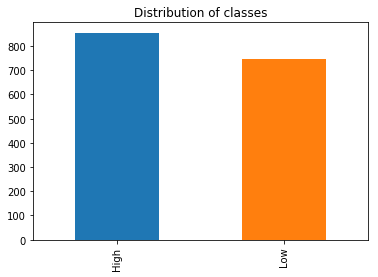

In [108]:
# Creating the class attribute
wine['class'] = ['Low' if i <= 5 else "High" for i in wine.quality]
wine['class'].value_counts().plot(kind = 'bar', title = 'Distribution of classes')

# Dropping quality attribute
wine.drop(columns = ['quality'], inplace = True)

# Paritioning dependent attributes from the independent attributes
wine_data = wine[wine.columns[wine.columns != 'class']].copy()
wine_label = wine['class'].copy()
print(pd.DataFrame(wine_label.value_counts()))

---
## 2. Preliminary Data Analysis

In [109]:
printmd('## 2.1. Data Snapshot')
wine.head()

## 2.1. Data Snapshot

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Low
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Low
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Low
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,High
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Low


In [110]:
printmd('## 2.2. Summary Statistics')
wine_data.describe()

## 2.2. Summary Statistics

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [111]:
printmd('## 2.3. Correlation Matrix')
wine_data.corr(method = 'pearson')

## 2.3. Correlation Matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


In [112]:
printmd('## 2.3.1 Top Correlated Pairs')
correlated_pairs = wine_data.corr()
top_correlated_pairs = correlated_pairs.unstack().sort_values(kind="quicksort")
pd.DataFrame(top_correlated_pairs[((top_correlated_pairs < -0.5) & (top_correlated_pairs > -1)) | ((top_correlated_pairs>0.5) & (top_correlated_pairs <1))], columns = ['Coefficient'])

## 2.3.1 Top Correlated Pairs

,,Coefficient
pH,fixed acidity,-0.682978
fixed acidity,pH,-0.682978
volatile acidity,citric acid,-0.552496
citric acid,volatile acidity,-0.552496
pH,citric acid,-0.541904
citric acid,pH,-0.541904
free sulfur dioxide,total sulfur dioxide,0.667666
total sulfur dioxide,free sulfur dioxide,0.667666
density,fixed acidity,0.668047
fixed acidity,density,0.668047


---
## 3. Data Transformations

In [113]:
# Dropping fixed acidity attribute
wine_data.drop(columns = ['fixed acidity','total sulfur dioxide'], inplace = True)

## Boxplot

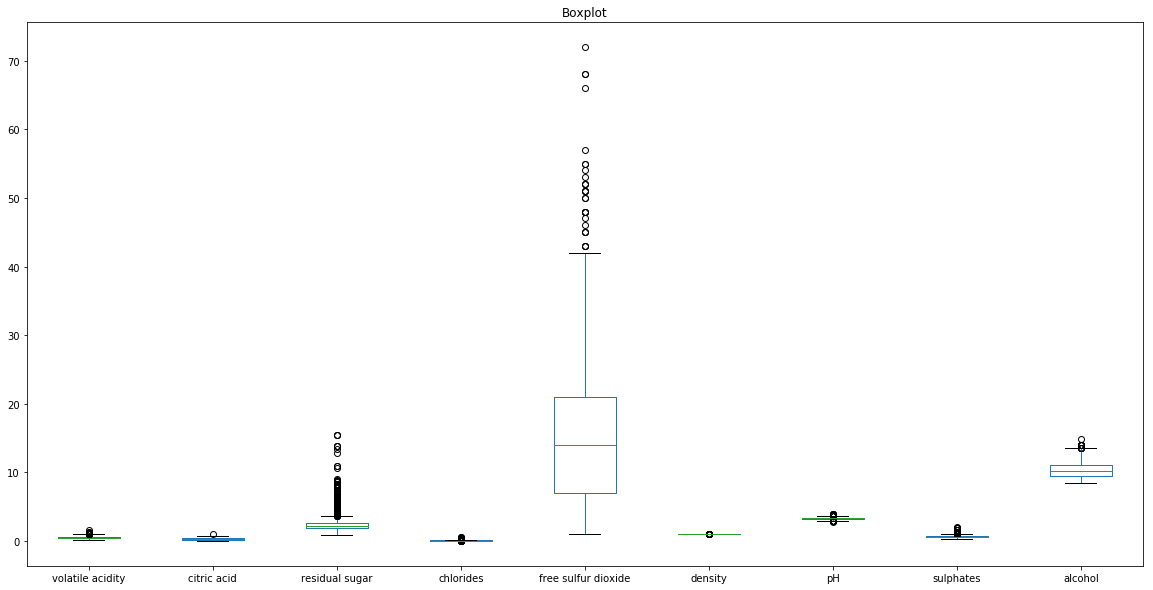

In [114]:
printmd('## Boxplot')
wine_data.plot(kind = 'box', figsize = (20,10), title = 'Boxplot')

## Outlier Analysis

### Boxplot

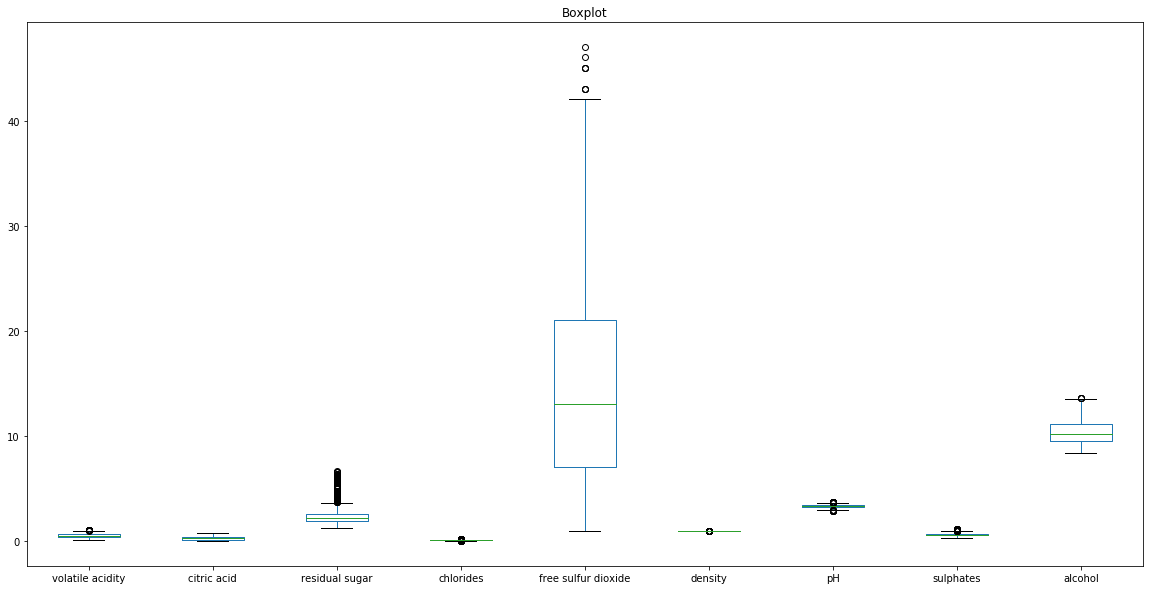

In [115]:
printmd('## Outlier Analysis')
# Removing outliers
# Keeping records where the column values are within +3/-3 standard deviations from the mean

outlier_filter = (np.abs(wine_data - wine_data.mean()) <= (3*wine_data.std())).all(1)
wine_data = wine_data[outlier_filter] 
wine_label = wine_label[outlier_filter]

printmd('### Boxplot')
wine_data.plot(kind = 'box', figsize = (20,10), title = 'Boxplot')
print()

---
## 4. Splitting data into train/test

In [116]:
X = np.array(wine_data)
y = np.array(wine_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

---
## 5. Model Development

In [117]:
def euclidian_distance(A, B):
    if not (A.ndim == 1 and B.ndim == 1):
        raise ValueError("Both numpy arrays should be single rows (1 dimensional).")
    return np.sqrt(np.sum(np.square(A - B)))

def cosine_similarity(A, B):
    if not (A.ndim == 1 and B.ndim == 1):
        raise ValueError("Both numpy arrays should be single rows (1 dimensional).")
    return np.sum(A*B)/(np.sqrt(np.sum(A*A)) * np.sqrt(np.sum(B*B)))


def predict(train_X, labels, test, K, metric, measure):
    distances = []
    for i, sample in enumerate(train_X):
        if measure == EUCLID:
            distance = euclidian_distance(sample, test)
        elif measure == COSINE:
            distance = cosine_similarity(sample, test)
        distances.append((distance, i))

    distances.sort()

    return predict_label(distances, labels, K, metric, measure)

def predict_label(distances, labels, K, metric, measure):
    if metric == COUNT:
        k_closest = [labels[x[1]] for x in distances[:K]]
        counts = collections.Counter(k_closest)
        return counts.most_common()[0][0], counts.most_common()[0][1] / K
    if metric == DISTANCE_WEIGHTED:
        label_sum = {}
        max_sum = -1
        count = 0
        for distance, index in distances:
            if distance == 0: continue
            if count == K: break
            count += 1
            label_sum[labels[index]] = label_sum.get(labels[index], 0) + (1 / distance)
            if label_sum[labels[index]] > max_sum:
                max_sum = label_sum[labels[index]]
                predicted_label = labels[index]
        return predicted_label, max_sum / sum(label_sum.values())
    
def kNN(X_train, y_train, X_test, y_test, K, metric, measure):
    predicted = []
    for i, test in enumerate(X_test):
        predicted_class, posterior = predict(X_train, y_train, test, K, metric, measure)
        actual_class = y_test[i]
        predicted.append((actual_class, predicted_class, posterior))
    
    prediction = pd.DataFrame.from_records(predicted, columns=["Actual", "Predicted", "Posterior"])
    
    return prediction

def get_accuracy(prediction_df):
    return prediction_df[prediction_df["Actual"] == prediction_df["Predicted"]].shape[0] / prediction_df.shape[0]

In [118]:
# Maximum accuracy is found at K = 38 for the euclidian distance measure.
def optimal_K(metric, measure):
    K_candidates = range(1,50,2)
    errors = []
    for K in K_candidates:
        accuracy = get_accuracy(kNN(X_train, y_train, X_test, y_test, K, metric, measure))
        errors.append(1 - accuracy)
    
    plt.plot(K_candidates, errors)
    plt.show()
    return np.where(errors==np.min(errors))

In [119]:
def confusion_matrix(prediction_df):
    y = list(prediction_df.Actual)
    x = list(prediction_df.Predicted)
    if len(x) != len(y):
        return 'Length do not match'
    TP, TN, FP, FN = 0,0,0,0
    for i in range(len(x)):
        if y[i] == 'High':
            if x[i] == 'High':
                TP += 1
            else:
                FN += 1
        else:
            if x[i] == 'High':
                FP += 1
            else:
                TN += 1
    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    return accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate

def optimal_K_confusion(metric, measure):
    K_candidates = range(1,50,2)
    out = {}
    for K in K_candidates:
        accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate = confusion_matrix(kNN(X_train, y_train, X_test, y_test, K, metric, measure))
        out['K'] = out.get('K',[]) + [K]
        out['f_measure'] = out.get('f_measure',[]) + [f_measure]
        out['sensitivity'] = out.get('sensitivity',[]) + [sensitivity]
        out['specificity'] = out.get('specificity',[]) + [specificity]
        out['error_rate'] = out.get('error_rate',[]) + [error_rate]
        out['accuracy'] = out.get('accuracy',[]) + [accuracy]
        out['precision'] = out.get('precision',[]) + [precision]
        out['recall'] = out.get('recall',[]) + [recall]
        
    return pd.DataFrame(out)



---
## 6. Model Evaluation

In [15]:
printmd('### 6.1. kNN using COUNT method and Euclidean distance as proximity measure')
base_count_euclid = optimal_K_confusion(COUNT, EUCLID)
base_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.1. kNN using COUNT method and Euclidean distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.756098,0.243902,0.779412,0.807107,0.753555,0.753555,0.759494
11,23,0.658537,0.341463,0.698565,0.705314,0.691943,0.691943,0.613924
17,35,0.674797,0.325203,0.695431,0.748634,0.649289,0.649289,0.708861
15,31,0.666667,0.333333,0.694789,0.729167,0.663507,0.663507,0.670886
19,39,0.669377,0.330623,0.693467,0.737968,0.654028,0.654028,0.689873
14,29,0.663957,0.336043,0.693069,0.725389,0.663507,0.663507,0.664557
13,27,0.661247,0.338753,0.692875,0.719388,0.668246,0.668246,0.651899
1,3,0.658537,0.341463,0.692683,0.713568,0.672986,0.672986,0.639241
10,21,0.653117,0.346883,0.692308,0.702439,0.682464,0.682464,0.613924
18,37,0.672087,0.327913,0.692112,0.747253,0.644550,0.644550,0.708861


In [52]:
printmd('### 6.2. kNN using COUNT method and Cosine distance as proximity measure')
base_count_cosine = optimal_K_confusion(COUNT, COSINE)
base_count_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.2. kNN using COUNT method and Cosine distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.490515,0.509485,0.570776,0.550661,0.592417,0.592417,0.354430
19,39,0.490515,0.509485,0.562791,0.552511,0.573460,0.573460,0.379747
20,41,0.490515,0.509485,0.562791,0.552511,0.573460,0.573460,0.379747
23,47,0.490515,0.509485,0.562791,0.552511,0.573460,0.573460,0.379747
21,43,0.487805,0.512195,0.561485,0.550000,0.573460,0.573460,0.373418
22,45,0.487805,0.512195,0.561485,0.550000,0.573460,0.573460,0.373418
18,37,0.487805,0.512195,0.559441,0.550459,0.568720,0.568720,0.379747
24,49,0.487805,0.512195,0.559441,0.550459,0.568720,0.568720,0.379747
12,25,0.487805,0.512195,0.557377,0.550926,0.563981,0.563981,0.386076
13,27,0.487805,0.512195,0.557377,0.550926,0.563981,0.563981,0.386076


In [53]:
printmd('### 6.3. kNN using Weighted Distance method and Euclidean distance as proximity measure')
base_DW_euclid = optimal_K_confusion(DISTANCE_WEIGHTED, EUCLID)
base_DW_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.3. kNN using Weighted Distance method and Euclidean distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
19,39,0.672087,0.327913,0.696742,0.739362,0.658768,0.658768,0.689873
20,41,0.669377,0.330623,0.696517,0.732984,0.663507,0.663507,0.677215
21,43,0.669377,0.330623,0.695000,0.735450,0.658768,0.658768,0.683544
18,37,0.663957,0.336043,0.688442,0.732620,0.649289,0.649289,0.683544
22,45,0.663957,0.336043,0.688442,0.732620,0.649289,0.649289,0.683544
8,17,0.647696,0.352304,0.687500,0.697561,0.677725,0.677725,0.607595
0,1,0.655827,0.344173,0.686420,0.716495,0.658768,0.658768,0.651899
11,23,0.644986,0.355014,0.685851,0.694175,0.677725,0.677725,0.601266
17,35,0.661247,0.338753,0.685139,0.731183,0.644550,0.644550,0.683544
23,47,0.655827,0.344173,0.681704,0.723404,0.644550,0.644550,0.670886


In [54]:
printmd('### 6.4. kNN using Weighted Distance method and Cosine distance as proximity measure')
base_DW_cosine = optimal_K_confusion(DISTANCE_WEIGHTED, COSINE)
base_DW_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.4. kNN using Weighted Distance method and Cosine distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.490515,0.509485,0.570776,0.550661,0.592417,0.592417,0.354430
19,39,0.490515,0.509485,0.562791,0.552511,0.573460,0.573460,0.379747
20,41,0.490515,0.509485,0.562791,0.552511,0.573460,0.573460,0.379747
23,47,0.490515,0.509485,0.562791,0.552511,0.573460,0.573460,0.379747
21,43,0.487805,0.512195,0.561485,0.550000,0.573460,0.573460,0.373418
22,45,0.487805,0.512195,0.561485,0.550000,0.573460,0.573460,0.373418
18,37,0.487805,0.512195,0.559441,0.550459,0.568720,0.568720,0.379747
24,49,0.487805,0.512195,0.559441,0.550459,0.568720,0.568720,0.379747
12,25,0.487805,0.512195,0.557377,0.550926,0.563981,0.563981,0.386076
13,27,0.487805,0.512195,0.557377,0.550926,0.563981,0.563981,0.386076


In [55]:
printmd('### Normalizing the data using mix-max method')
X_train, X_test, Y_train, Y_test = train_test_split(wine_data, wine_label, test_size=0.25, random_state=42)
X_train_norm = (X_train - X_train.min()) / (X_train.max() -  X_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() -  X_train.min())
X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


### Normalizing the data using mix-max method

In [56]:
printmd('### 6.5. kNN using COUNT method and Euclidean distance as proximity measure on Normalized Data')
norm_count_euclid = optimal_K_confusion(COUNT, EUCLID)
norm_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.5. kNN using COUNT method and Euclidean distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
4,9,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873
22,45,0.728997,0.271003,0.754902,0.781726,0.729858,0.729858,0.727848
23,47,0.726287,0.273713,0.751843,0.780612,0.725118,0.725118,0.727848
6,13,0.720867,0.279133,0.751807,0.764706,0.739336,0.739336,0.696203
21,43,0.723577,0.276423,0.751220,0.773869,0.729858,0.729858,0.715190
13,27,0.715447,0.284553,0.749403,0.754808,0.744076,0.744076,0.677215
2,5,0.712737,0.287263,0.748815,0.748815,0.748815,0.748815,0.664557
12,25,0.718157,0.281843,0.748792,0.763547,0.734597,0.734597,0.696203
24,49,0.723577,0.276423,0.748768,0.779487,0.720379,0.720379,0.727848
17,35,0.715447,0.284553,0.748201,0.757282,0.739336,0.739336,0.683544


In [57]:
printmd('### 6.6. kNN using COUNT method and Cosine distance as proximity measure on Normalized Data')
norm_count_cosine = optimal_K_confusion(COUNT, COSINE)
norm_count_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.6. kNN using COUNT method and Cosine distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
1,3,0.411924,0.588076,0.570297,0.489796,0.682464,0.682464,0.050633
0,1,0.401084,0.598916,0.560636,0.482877,0.668246,0.668246,0.044304
3,7,0.398374,0.601626,0.554217,0.480836,0.654028,0.654028,0.056962
2,5,0.398374,0.601626,0.552419,0.480702,0.649289,0.649289,0.063291
4,9,0.390244,0.609756,0.534161,0.474265,0.611374,0.611374,0.094937
5,11,0.384824,0.615176,0.522105,0.469697,0.587678,0.587678,0.113924
6,13,0.371274,0.628726,0.508475,0.459770,0.568720,0.568720,0.107595
7,15,0.363144,0.636856,0.505263,0.454545,0.568720,0.568720,0.088608
8,17,0.355014,0.644986,0.500000,0.449057,0.563981,0.563981,0.075949
15,31,0.357724,0.642276,0.496815,0.450000,0.554502,0.554502,0.094937


In [58]:
printmd('### 6.7. kNN using Weighted Distance method and Euclidean distance as proximity measure on Normalized Data')
norm_DW_euclid = optimal_K_confusion(DISTANCE_WEIGHTED, EUCLID)
norm_DW_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.7. kNN using Weighted Distance method and Euclidean distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
21,43,0.731707,0.268293,0.761446,0.774510,0.748815,0.748815,0.708861
8,17,0.726287,0.273713,0.760095,0.761905,0.758294,0.758294,0.683544
22,45,0.734417,0.265583,0.759804,0.786802,0.734597,0.734597,0.734177
6,13,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873
16,33,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873
18,37,0.728997,0.271003,0.758454,0.773399,0.744076,0.744076,0.708861
19,39,0.728997,0.271003,0.758454,0.773399,0.744076,0.744076,0.708861
13,27,0.723577,0.276423,0.758294,0.758294,0.758294,0.758294,0.677215
20,41,0.726287,0.273713,0.756627,0.769608,0.744076,0.744076,0.702532
12,25,0.723577,0.276423,0.755981,0.763285,0.748815,0.748815,0.689873


In [59]:
printmd('### 6.8. kNN using Weighted Distance method and Cosine distance as proximity measure on Normalized Data')
norm_DW_cosine = optimal_K_confusion(DISTANCE_WEIGHTED, COSINE)
norm_DW_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.8. kNN using Weighted Distance method and Cosine distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
1,3,0.411924,0.588076,0.570297,0.489796,0.682464,0.682464,0.050633
0,1,0.401084,0.598916,0.560636,0.482877,0.668246,0.668246,0.044304
3,7,0.398374,0.601626,0.554217,0.480836,0.654028,0.654028,0.056962
2,5,0.398374,0.601626,0.552419,0.480702,0.649289,0.649289,0.063291
4,9,0.390244,0.609756,0.534161,0.474265,0.611374,0.611374,0.094937
5,11,0.384824,0.615176,0.522105,0.469697,0.587678,0.587678,0.113924
6,13,0.373984,0.626016,0.511628,0.461832,0.573460,0.573460,0.107595
7,15,0.363144,0.636856,0.505263,0.454545,0.568720,0.568720,0.088608
8,17,0.355014,0.644986,0.500000,0.449057,0.563981,0.563981,0.075949
15,31,0.357724,0.642276,0.496815,0.450000,0.554502,0.554502,0.094937


In [60]:
printmd('### 6.9. kNN with only 50% data')

wine2, wine2_n = train_test_split(wine, test_size = 0.5)
wine_data = wine2[wine2.columns[wine.columns != 'class']].copy()
wine_label = wine2['class'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(wine_data, wine_label, test_size=0.25, random_state=42)
X_train_norm = (X_train - X_train.min()) / (X_train.max() -  X_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() -  X_train.min())
X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

f_base_count_euclid = optimal_K_confusion(COUNT, EUCLID)
f_base_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.9. kNN with only 50% data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
23,47,0.490,0.510,0.633094,0.508671,0.838095,0.838095,0.105263
24,49,0.490,0.510,0.630435,0.508772,0.828571,0.828571,0.115789
21,43,0.495,0.505,0.630037,0.511905,0.819048,0.819048,0.136842
16,33,0.505,0.495,0.626415,0.518750,0.790476,0.790476,0.189474
17,35,0.505,0.495,0.626415,0.518750,0.790476,0.790476,0.189474
19,39,0.495,0.505,0.624535,0.512195,0.800000,0.800000,0.157895
22,45,0.470,0.530,0.613139,0.497041,0.800000,0.800000,0.105263
20,41,0.475,0.525,0.612546,0.500000,0.790476,0.790476,0.126316
15,31,0.485,0.515,0.605364,0.506410,0.752381,0.752381,0.189474
13,27,0.490,0.510,0.604651,0.509804,0.742857,0.742857,0.210526


In [61]:
printmd('### 6.10. Comparing with off the shelf KNN classifiers')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

wine_data = wine[wine.columns[wine.columns != 'class']].copy()
wine_label = wine[wine.columns[wine.columns == 'class']].copy()
wine_data.drop(columns = ['fixed acidity','total sulfur dioxide'], inplace = True)
out = {}
train_data, test_data, train_label, test_label = train_test_split(wine_data, wine_label, train_size = 0.75, test_size = 0.25, random_state = 42) 

K_candidates = range(1,50,2)
out = {}
for K in K_candidates:
    knn = KNeighborsClassifier(algorithm='auto',  metric='minkowski', 
                               metric_params=None, n_jobs=-1, n_neighbors=K, p=2,
                           weights='uniform')
    knn.fit(train_data, train_label['class']) 
    accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate = confusion_matrix(pd.DataFrame({'Actual' : test_label['class'],'Predicted' : knn.predict(test_data)}))
    out['K'] = out.get('K',[]) + [K]
    out['f_measure'] = out.get('f_measure',[]) + [f_measure]
    out['sensitivity'] = out.get('sensitivity',[]) + [sensitivity]
    out['specificity'] = out.get('specificity',[]) + [specificity]
    out['error_rate'] = out.get('error_rate',[]) + [error_rate]
    out['accuracy'] = out.get('accuracy',[]) + [accuracy]
    out['precision'] = out.get('precision',[]) + [precision]
    out['recall'] = out.get('recall',[]) + [recall]
off_shelf = pd.DataFrame(out).sort_values(by = ['f_measure', 'accuracy'], ascending = False)
off_shelf

### 6.10. Comparing with off the shelf KNN classifiers

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.7150,0.2850,0.750000,0.730769,0.770270,0.770270,0.646067
1,3,0.6900,0.3100,0.726872,0.711207,0.743243,0.743243,0.623596
2,5,0.6825,0.3175,0.710706,0.718894,0.702703,0.702703,0.657303
3,7,0.6900,0.3100,0.707547,0.742574,0.675676,0.675676,0.707865
10,21,0.6900,0.3100,0.707547,0.742574,0.675676,0.675676,0.707865
5,11,0.6850,0.3150,0.704225,0.735294,0.675676,0.675676,0.696629
4,9,0.6800,0.3200,0.702326,0.725962,0.680180,0.680180,0.679775
13,27,0.6750,0.3250,0.696262,0.723301,0.671171,0.671171,0.679775
9,19,0.6775,0.3225,0.695035,0.731343,0.662162,0.662162,0.696629
8,17,0.6725,0.3275,0.690307,0.726368,0.657658,0.657658,0.691011


---
## 7. Overall Metrics

In [62]:
off_shelf['Model'] = 'off_shelf'
base_count_euclid['Model'] = 'base_count_euclid'
base_count_cosine['Model'] = 'base_count_cosine'
base_DW_euclid['Model'] = 'base_DW_euclid'
base_DW_cosine['Model'] = 'base_DW_cosine'
norm_count_euclid['Model'] = 'norm_count_euclid'
norm_count_cosine['Model'] = 'norm_count_cosine'
norm_DW_euclid['Model'] = 'norm_DW_euclid'
norm_DW_cosine['Model'] = 'norm_DW_cosine'
f_base_count_euclid['Model'] = 'half_data_base_count_euclid'

overall_score = pd.concat([off_shelf, base_count_euclid, base_count_cosine, base_DW_euclid, base_DW_cosine, \
                   norm_count_euclid, norm_count_cosine, norm_DW_euclid, norm_DW_cosine, f_base_count_euclid])
overall_score.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity,Model
0,1,0.756098,0.243902,0.779412,0.807107,0.753555,0.753555,0.759494,base_count_euclid
21,43,0.731707,0.268293,0.761446,0.774510,0.748815,0.748815,0.708861,norm_DW_euclid
8,17,0.726287,0.273713,0.760095,0.761905,0.758294,0.758294,0.683544,norm_DW_euclid
22,45,0.734417,0.265583,0.759804,0.786802,0.734597,0.734597,0.734177,norm_DW_euclid
4,9,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873,norm_count_euclid
6,13,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873,norm_DW_euclid
16,33,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873,norm_DW_euclid
18,37,0.728997,0.271003,0.758454,0.773399,0.744076,0.744076,0.708861,norm_DW_euclid
19,39,0.728997,0.271003,0.758454,0.773399,0.744076,0.744076,0.708861,norm_DW_euclid
13,27,0.723577,0.276423,0.758294,0.758294,0.758294,0.758294,0.677215,norm_DW_euclid


In [66]:
ovsc = overall_score.sort_values(by = ['f_measure', 'accuracy'], ascending = False)
ovsc.head(10)

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity,Model
0,1,0.756098,0.243902,0.779412,0.807107,0.753555,0.753555,0.759494,base_count_euclid
21,43,0.731707,0.268293,0.761446,0.774510,0.748815,0.748815,0.708861,norm_DW_euclid
8,17,0.726287,0.273713,0.760095,0.761905,0.758294,0.758294,0.683544,norm_DW_euclid
22,45,0.734417,0.265583,0.759804,0.786802,0.734597,0.734597,0.734177,norm_DW_euclid
4,9,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873,norm_count_euclid
6,13,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873,norm_DW_euclid
16,33,0.726287,0.273713,0.758950,0.764423,0.753555,0.753555,0.689873,norm_DW_euclid
18,37,0.728997,0.271003,0.758454,0.773399,0.744076,0.744076,0.708861,norm_DW_euclid
19,39,0.728997,0.271003,0.758454,0.773399,0.744076,0.744076,0.708861,norm_DW_euclid
13,27,0.723577,0.276423,0.758294,0.758294,0.758294,0.758294,0.677215,norm_DW_euclid


In [127]:
def generateRoc_ovl(ovall, X_train, y_train, X_test, y_test, top):
    
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    plt.figure()

    for i in range(top):
#         print(i)        
#         if ovall.iloc[i]["K"] == 1:
#             continue

        if 'count' in ovall.iloc[i]["Model"].lower():
            STYLE = COUNT
        else:
            STYLE = DISTANCE_WEIGHTED
        if 'euclid' in ovall.iloc[i]["Model"].lower():
            METRIC = EUCLID
        else:
            METRIC = COSINE
                
        x = kNN(X_train, y_train, X_test, y_test, ovall.iloc[i]["K"], STYLE, METRIC)
        yt = label_binarize(y_test, classes=['Low', 'High'])
        y_score = x.Posterior
        fpr, tpr, thres = metrics.roc_curve(yt.ravel(),y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, color=color[i % len(color)],lw=lw, label='K = ' + str(ovall.iloc[i]["K"]) + " " + ovall.iloc[i]["Model"].lower())
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC)')
        plt.legend(loc="lower right")

    plt.show()

In [100]:
def generateRoc(X_train, y_train, X_test, y_test, k_min, k_max, STYLE, METRIC):
    
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    plt.figure()
    for i in range(k_min, k_max+1, 2):
        
        x = kNN(X_train, y_train, X_test, y_test, i, STYLE, METRIC)
        yt = label_binarize(y_test, classes=['Low', 'High'])
        y_score = x.Posterior
        fpr, tpr, thres = metrics.roc_curve(yt.ravel(),y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, color=color[i % len(color)],lw=lw, label='K = ' + str(i))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC)')
        plt.legend(loc="lower right")

    plt.show()

---
## 8. ROC Curve

**Varying K value**

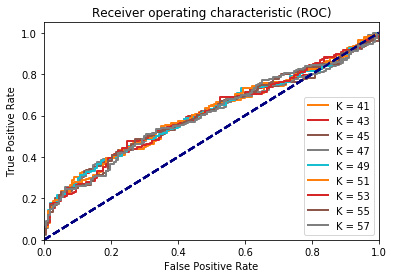

In [130]:
printmd('**Varying K value**')
generateRoc(X_train, y_train, X_test, y_test, 41, 57, DISTANCE_WEIGHTED, EUCLID)

**Model with top F-score**

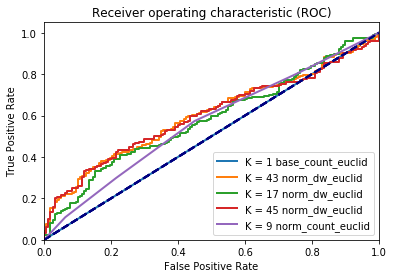

In [131]:
printmd('**Model with top F-score**')
generateRoc_ovl(ovsc, X_train, y_train, X_test, y_test, 5)
